## import & utils


In [8]:
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
from tqdm.auto import trange
import jraph
import numpy as np

pl.style.use("dark_background")


def np2pil(a):
    a = np.asarray(a)
    if a.dtype.kind == "f":
        a = np.uint8(a.clip(0, 1) * 255)
    return PIL.Image.fromarray(a)


def imshow(a):
    display(np2pil(a))


def zoom(a, k=2):
    return np.repeat(np.repeat(a, k, 1), k, 0)


def tile2d(a, w=None):
    a = np.asarray(a)
    if w is None:
        w = int(np.ceil(np.sqrt(len(a))))
    th, tw = a.shape[1:3]
    pad = (w - len(a)) % w
    a = np.pad(a, [(0, pad)] + [(0, 0)] * (a.ndim - 1), "constant")
    h = len(a) // w
    a = a.reshape([h, w] + list(a.shape[1:]))
    a = np.rollaxis(a, 2, 1).reshape([th * h, tw * w] + list(a.shape[4:]))
    return a

In [1]:
import jax
import jax.numpy as jp
import optax
from flax import nnx

In [2]:
%load_ext autoreload
%autoreload 2

## Params

In [3]:
from boolean_nca_cc import generate_layer_sizes

In [57]:
input_n, output_n = 4, 4
arity = 3
layer_sizes = generate_layer_sizes(input_n, output_n, arity, layer_n=4)
loss_type = "l4"

In [59]:
layer_sizes

[(4, 1), (24, 3), (24, 3), (24, 3), (12, 1), (4, 1)]

## Training


### BackProp

In [60]:
from boolean_nca_cc.circuits.model import gen_circuit
from boolean_nca_cc.circuits.train import TrainState, train_step
from boolean_nca_cc.circuits.viz import evaluate_and_visualize
from boolean_nca_cc.circuits.tasks import get_task_data

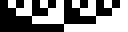

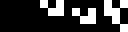

In [61]:
key = jax.random.PRNGKey(42)
wires, logitsbp = gen_circuit(key, layer_sizes, arity=arity)

opt = optax.adamw(1, 0.8, 0.8, weight_decay=1e-1)
state = TrainState(params=logitsbp, opt_state=opt.init(logitsbp))


case_n = 1 << input_n
x = jp.arange(case_n)
x, y0 = get_task_data(
    "binary_multiply", case_n, input_bits=input_n, output_bits=output_n
)

zoom_factor = 8
imshow(zoom(x.T, zoom_factor))
imshow(zoom(y0.T, zoom_factor))

In [62]:
loss_log_bp = []
aux_log_bp = []

In [63]:
pbar = trange(100)
for i in pbar:
    loss, aux, state = train_step(state, opt, wires, x, y0, loss_type, do_train=True)
    loss_log_bp.append(loss)
    aux_log_bp.append(aux)
    pbar.set_postfix_str(
        f"loss: {loss.item():.3E}, accuracy: {aux['accuracy'].item():.2%}"
        + (
            f" | hard_loss: {aux['hard_loss'].item():.3E}, hard_accuracy: {aux['hard_accuracy'].item():.2%}"
            if "hard_loss" in aux
            else ""
        )
    )

  0%|          | 0/100 [00:00<?, ?it/s]

In [64]:
%timeit train_step(state, opt, wires, x, y0, loss_type, do_train=True)

5.17 ms ± 294 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


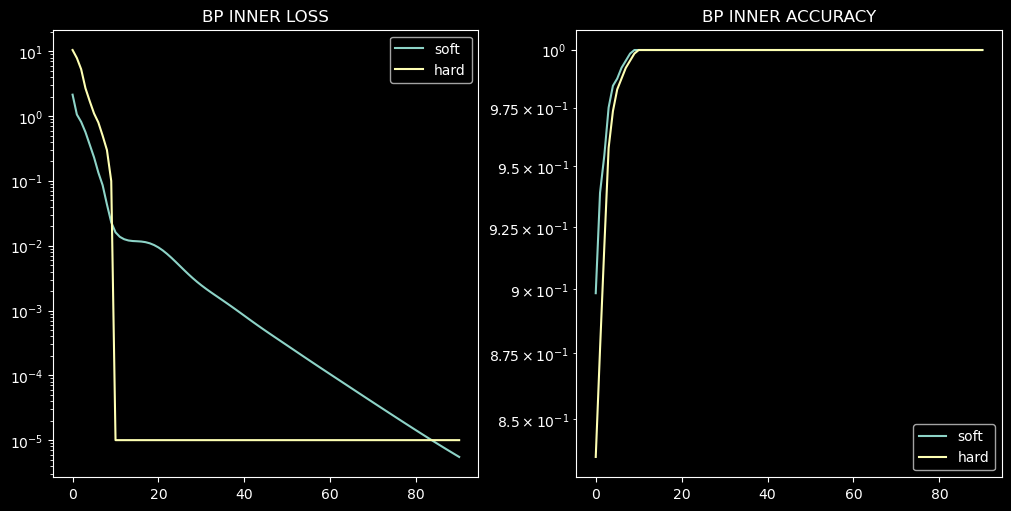

In [65]:
def plot_losses(
    loss_log, aux_log, figax=None, title=None, plot_accuracy=False, plot_hard=True
):
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax
    v = len(loss_log) // 10

    if not plot_accuracy:
        smooth_losses = np.convolve(loss_log, np.ones(v) / v, mode="valid")
        hard_losses = [aux["hard_loss"] for aux in aux_log]
        smooth_hard_losses = np.convolve(hard_losses, np.ones(v) / v, mode="valid")
        ax.plot(smooth_losses, label="soft")
        if plot_hard:
            ax.plot(jp.maximum(smooth_hard_losses, 1e-5), label="hard")
    else:
        accs = [aux["accuracy"] for aux in aux_log]
        smooth_accs = np.convolve(accs, np.ones(v) / v, mode="valid")
        ax.plot(smooth_accs, label="soft")
        hard_accs = [aux["hard_accuracy"] for aux in aux_log]
        smooth_hard_accs = np.convolve(hard_accs, np.ones(v) / v, mode="valid")
        if plot_hard:
            ax.plot(smooth_hard_accs, label="hard")

    ax.legend()
    ax.set_yscale("log")

    if title is not None:
        ax.set_title(title)


fig, axs = plt.subplots(
    1, 2, figsize=(10, 5), sharey=False, sharex=True, constrained_layout=True
)
plot_losses(loss_log_bp, aux_log_bp, (fig, axs[0]), title="BP INNER LOSS")
plot_losses(
    loss_log_bp,
    aux_log_bp,
    (fig, axs[1]),
    plot_accuracy=True,
    title="BP INNER ACCURACY",
)

In [66]:
bp_results = {
    "losses": loss_log_bp,
    "aux_log": aux_log_bp,
}

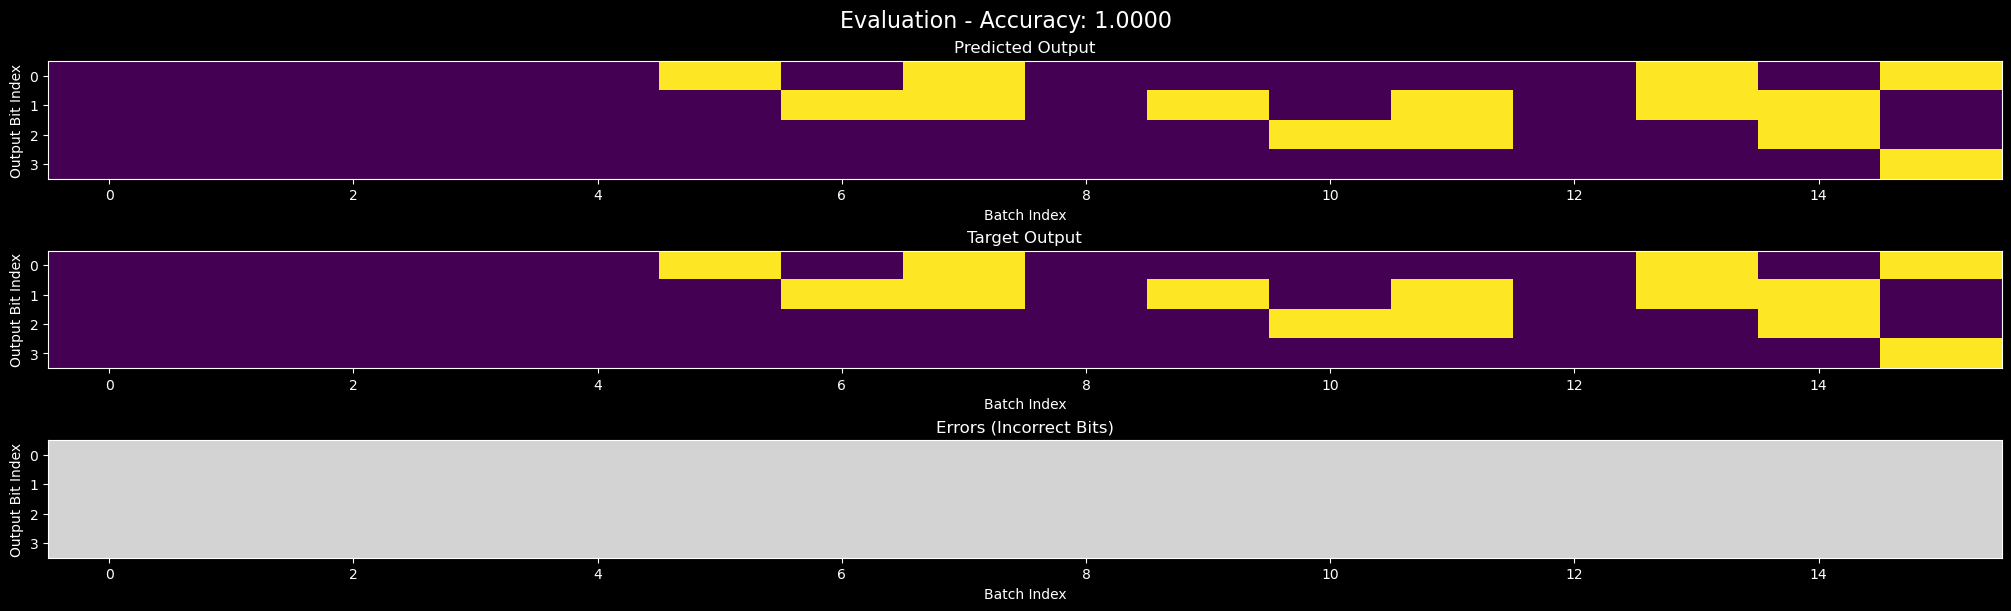

In [67]:
metrics = evaluate_and_visualize(state.params, wires, x, y0, hard=True)

In [68]:
raise KeyboardInterrupt()

KeyboardInterrupt: 

In [69]:
from boolean_nca_cc.utils import build_graph, extract_logits_from_graph
from boolean_nca_cc.circuits.train import loss_f_l4

### GNN

In [70]:
from boolean_nca_cc.models import CircuitGNN, run_gnn_scan
from boolean_nca_cc.training import train_gnn

In [72]:
hidden_dim = 64
hidden_features = 64
n_message_steps = 10
loss, aux = loss_f_l4(logitsbp, wires, x, y0)
graph = build_graph(
    logitsbp, wires, input_n, arity, hidden_dim=hidden_dim, loss_value=loss
)

gnn = CircuitGNN(
    hidden_dim=hidden_dim,
    message_passing=True,
    node_mlp_features=[hidden_features, hidden_features],
    edge_mlp_features=[hidden_features, hidden_features],
    rngs=nnx.Rngs(params=jax.random.PRNGKey(42)),
    use_attention=True,
    arity=arity,
)

opt_fn = optax.adamw(1e-3, weight_decay=1e-5)
opt = nnx.Optimizer(gnn, opt_fn)

In [73]:
def loss_fn(gnn: CircuitGNN, graph: jraph.GraphsTuple, wires: jax.Array = wires):
    updated_graph = run_gnn_scan(gnn, graph, n_message_steps)
    updated_logits = extract_logits_from_graph(
        updated_graph, [l.shape for l in logitsbp]
    )
    loss, aux = loss_f_l4(updated_logits, wires, x, y0)
    return loss, updated_graph

In [20]:
(loss, aux), grads = nnx.value_and_grad(loss_fn, has_aux=True)(gnn, graph)
opt.update(grads)
(loss, aux), grads = nnx.value_and_grad(loss_fn, has_aux=True)(gnn, graph)
assert any(jax.tree.leaves(jax.tree.map(lambda x: x.any(), grads))), "No grads"

### Training

In [ ]:
gnn_results = train_gnn(
    # CIRCUIT PARAMS
    layer_sizes=layer_sizes,
    x_data=x,
    y_data=y0,
    arity=arity,
    # TRAINING PARAMS
    epochs=2**12,
    n_message_steps=n_message_steps,
    key=42,
    # META-LEARNING PARAMS
    meta_batch_size=256,
    meta_learning=True,
    # LOSS PARAMS
    loss_type="l4",
    # LEARNING RATE SCHEDULER
    lr_scheduler="linear_warmup",
    # MESSAGE STEPS SCHEDULE
    message_steps_schedule=None,
    # INITIAL GNN AND OPTIMIZER
    hidden_dim=hidden_dim,
    init_gnn=gnn,
    # init_optimizer=opt,
    # POOL PARAMS
    use_pool=True,
    pool_size=1024,
    reset_pool_fraction=0.05,
    reset_pool_interval=2**5,
    # reset_pool_interval=None,
)

Training GNN:   0%|          | 0/4096 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [29]:
try:
    gnn_results["gnn"] = nnx.state(gnn_results["gnn"])
    gnn_results["optimizer"] = nnx.state(gnn_results["optimizer"])
except ValueError:
    print("already converted")
    pass

In [30]:
# save gnn_results
import pickle

with open("gnn_results.pkl", "wb") as f:
    pickle.dump(gnn_results, f)

In [41]:
# recreate aux in old format
aux_log = [
    {
        "accuracy": accuracies,
        "hard_accuracy": hard_acc,
        "hard_loss": hard_loss,
    }
    for accuracies, hard_acc, hard_loss in zip(
        gnn_results["accuracies"],
        gnn_results["hard_accuracies"],
        gnn_results["hard_losses"],
    )
]

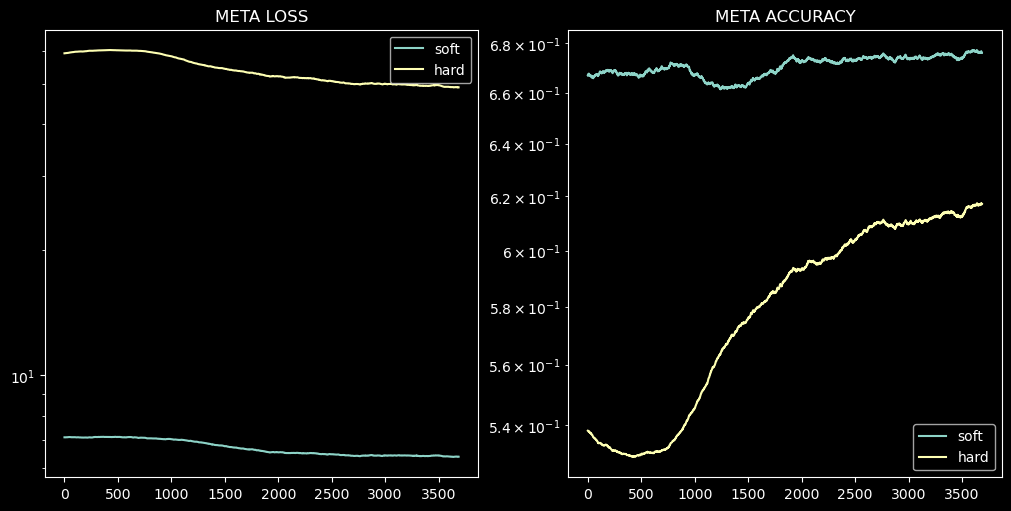

In [42]:
fig, axs = plt.subplots(
    1, 2, figsize=(10, 5), sharey=False, sharex=True, constrained_layout=True
)
plot_losses(
    gnn_results["losses"], aux_log, (fig, axs[0]), title="META LOSS", plot_hard=True
)
plot_losses(
    gnn_results["losses"],
    aux_log,
    (fig, axs[1]),
    plot_accuracy=True,
    title="META ACCURACY",
    plot_hard=True,
)

In [43]:
# Get the inner loop losses
from boolean_nca_cc.training.evaluation import evaluate_gnn_stepwise

In [50]:
key = jax.random.PRNGKey(42)
wires_gnn, logits_gnn = gen_circuit(key, layer_sizes, arity=arity)
step_metrics = evaluate_gnn_stepwise(
    gnn,
    wires_gnn,
    logits_gnn,
    x,
    y0,
    input_n,
    n_message_steps=100,
    arity=arity,
    hidden_dim=hidden_dim,
    loss_type="l4",
)

Evaluating GNN steps:   0%|          | 0/100 [00:00<?, ?it/s]

In [45]:
aux_log_stepwise = [
    {"accuracy": acc, "hard_accuracy": hard_acc, "hard_loss": hard_loss}
    for acc, hard_acc, hard_loss in zip(
        step_metrics["soft_accuracy"],
        step_metrics["hard_accuracy"],
        step_metrics["hard_loss"],
    )
]

In [46]:
step_metrics.keys()

dict_keys(['step', 'soft_loss', 'hard_loss', 'soft_accuracy', 'hard_accuracy'])

In [47]:
gnn_log_results = {
    "losses": step_metrics["soft_loss"],
    "aux_log": aux_log_stepwise,
}

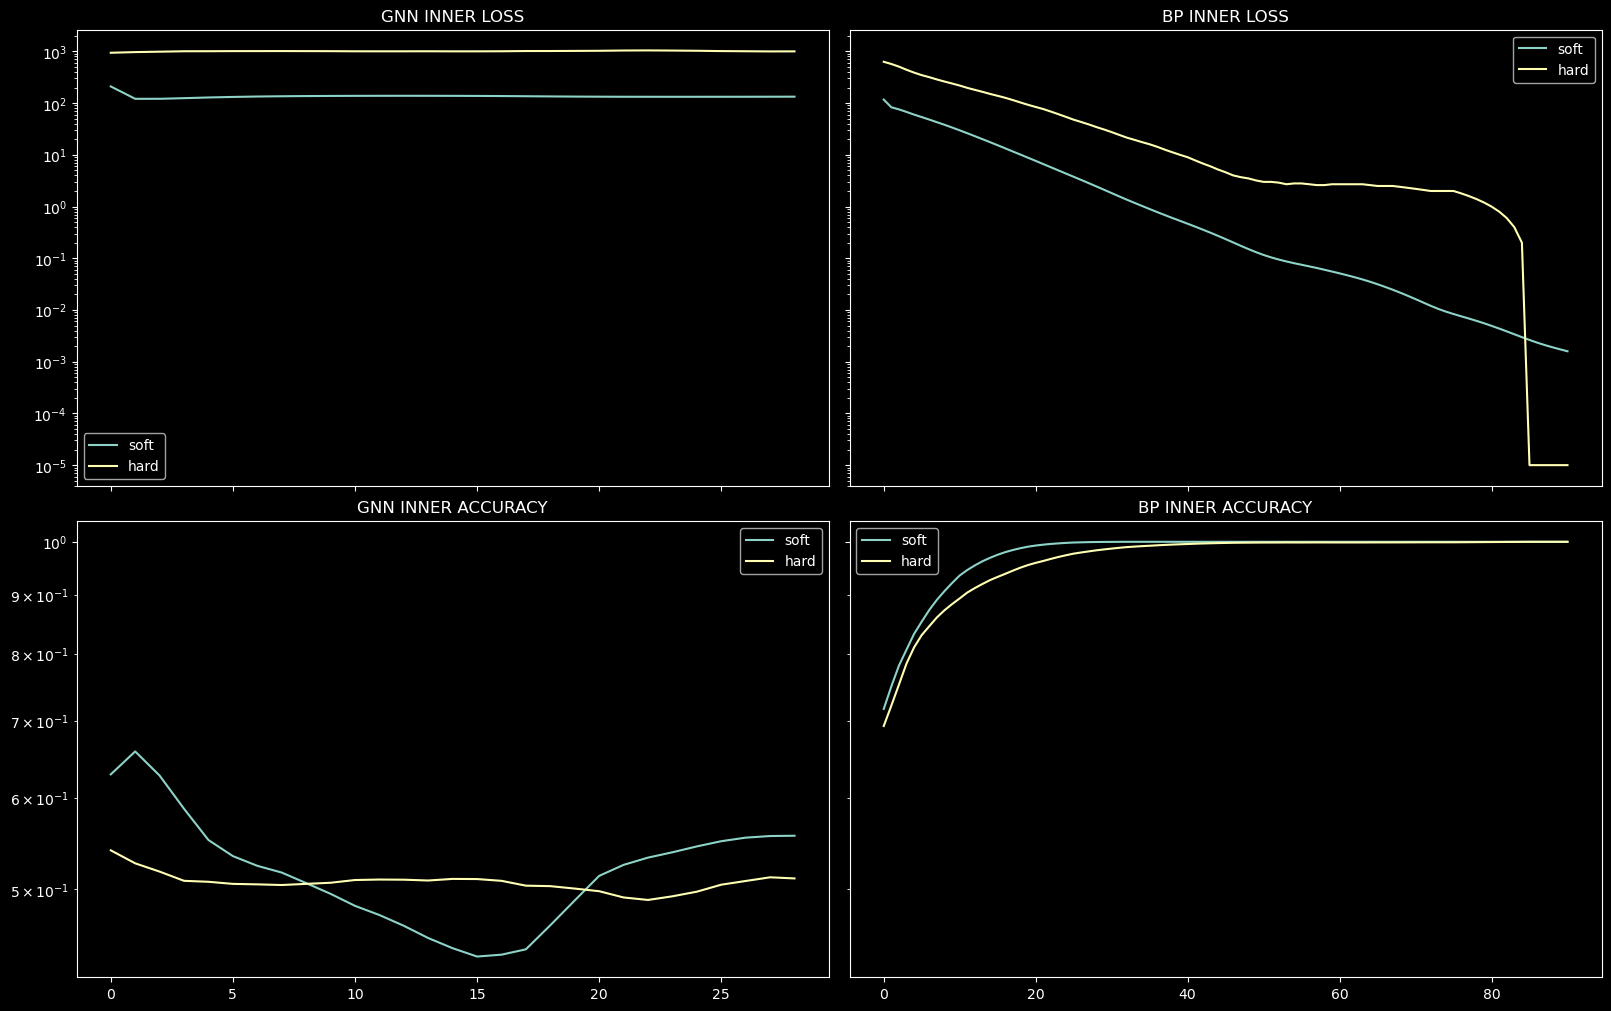

In [48]:
# Compare GNN and BP

fig, axs = plt.subplots(
    2, 2, figsize=(16, 10), sharey="row", sharex="col", constrained_layout=True
)

for method, axs_method, results in zip(
    ["GNN", "BP"], axs.T, [gnn_log_results, bp_results]
):
    for metric, ax in zip(["loss", "accuracy"], axs_method):
        if metric == "loss":
            plot_losses(
                results["losses"],
                results["aux_log"],
                (fig, ax),
                title=f"{method} INNER LOSS",
            )
        else:
            plot_losses(
                results["losses"],
                results["aux_log"],
                (fig, ax),
                title=f"{method} INNER ACCURACY",
                plot_accuracy=True,
            )

### Pool

In [23]:
from boolean_nca_cc.training.pool import GraphPool, initialize_graph_pool

In [24]:
init_pool = initialize_graph_pool(
    jax.random.PRNGKey(42),
    pool_size=1024,
    # circuit params
    layer_sizes=layer_sizes,
    arity=arity,
    input_n=input_n,
    # graph params
    hidden_dim=hidden_dim,
    loss_value=loss,
)

In [25]:
idxs, graphs, batch_of_wires, batch_of_logits = init_pool.sample(
    jax.random.PRNGKey(42), 16
)

In [26]:
graphs.nodes["logits"].sum(), idxs

(Array(0., dtype=float32),
 Array([ 196,   18,  183,  193,  653,  363,  385,  295,    6,  258,  552,
        1010,  409,  475,  972,  786], dtype=int32))

In [29]:
losses, updated_graphs = nnx.vmap(loss_fn, in_axes=(None, 0, 0))(
    gnn, graphs, batch_of_wires
)

In [30]:
updated_graphs.nodes["logits"].sum(), idxs

(Array(-152602.31, dtype=float32),
 Array([ 196,   18,  183,  193,  653,  363,  385,  295,    6,  258,  552,
        1010,  409,  475,  972,  786], dtype=int32))

In [31]:
updated_batch_of_logits = jax.vmap(extract_logits_from_graph, in_axes=(0, None))(
    updated_graphs, [l.shape[1:] for l in batch_of_logits]
)

In [32]:
new_pool = init_pool.update(idxs, updated_graphs)

In [33]:
new_idxs, new_graphs, new_batch_of_wires, new_batch_of_logits = new_pool.sample(
    jax.random.PRNGKey(42), 16
)

In [34]:
(
    new_graphs.nodes["logits"].sum(),
    sum(jax.tree.map(lambda x: x.sum(), new_batch_of_logits)),
)

# Update cprrect

(Array(-152602.31, dtype=float32), Array(-147320.38, dtype=float32))

In [36]:
new_pool = initialize_graph_pool(
    jax.random.PRNGKey(42),
    pool_size=1024,
    # circuit params
    layer_sizes=layer_sizes,
    arity=arity,
    input_n=input_n,
    # graph params
    hidden_dim=hidden_dim,
    loss_value=loss,
)

In [38]:
init_pool.reset_fraction(
    jax.random.PRNGKey(43), 0.1, new_pool.graphs, new_pool.wires, new_pool.logits
)

GraphPool(size=1024, graphs=GraphsTuple(nodes={'gate_id': Array([[  0,   1,   2, ..., 237, 238, 239],
       [  0,   1,   2, ..., 237, 238, 239],
       [  0,   1,   2, ..., 237, 238, 239],
       ...,
       [  0,   1,   2, ..., 237, 238, 239],
       [  0,   1,   2, ..., 237, 238, 239],
       [  0,   1,   2, ..., 237, 238, 239]], dtype=int32), 'group': Array([[0, 0, 0, ..., 5, 6, 7],
       [0, 0, 0, ..., 5, 6, 7],
       [0, 0, 0, ..., 5, 6, 7],
       ...,
       [0, 0, 0, ..., 5, 6, 7],
       [0, 0, 0, ..., 5, 6, 7],
       [0, 0, 0, ..., 5, 6, 7]], dtype=int32), 'hidden': Array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 

In [119]:
first_graph = jax.tree.map(lambda x: x[0], new_graphs)
first_graph.nodes["logits"].shape

first_logits = extract_logits_from_graph(
    first_graph, [l.shape[1:] for l in batch_of_logits]
)
sum(jax.tree.map(lambda x: x.sum(), first_logits)), first_graph.nodes["logits"].sum()

(Array(-2639.108, dtype=float32), Array(-2734.4316, dtype=float32))

## Attention

In [156]:
from boolean_nca_cc.models.self_attention import (
    CircuitSelfAttention,
    run_self_attention_scan,
)
from boolean_nca_cc.training import train_self_attention

In [19]:
hidden_dim = 64
hidden_features = 64
n_message_steps = 100
graph = build_graph(logitsbp, wires, input_n, arity, hidden_dim=hidden_dim)

In [30]:
circuit_attention = CircuitSelfAttention(
    hidden_dim=hidden_dim,
    num_heads=4,
    num_layers=2,
    arity=arity,
    dropout_rate=0.1,
    rngs=nnx.Rngs(params=jax.random.PRNGKey(42)),
    n_node=int(graph.n_node[0]),
)

opt_fn = optax.adamw(1e-3, weight_decay=1e-5)
opt = nnx.Optimizer(circuit_attention, opt_fn)

In [ ]:
updated_graph = circuit_attention(graph)

updated_graph = run_self_attention_scan(circuit_attention, graph, n_message_steps)

(1, 232, 16) 0.0 0.0 0.0
(1, 232, 16) Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>


In [24]:
def loss_fn_att(gnn: CircuitSelfAttention, graph: jraph.GraphsTuple):
    updated_graph = run_self_attention_scan(gnn, graph, n_message_steps)

    updated_logits = extract_logits_from_graph(
        updated_graph, [l.shape for l in logitsbp]
    )
    return loss_f_l4(updated_logits, wires, x, y0)

In [25]:
loss, aux = loss_fn_att(circuit_attention, graph)

In [26]:
(loss, aux), grads = nnx.value_and_grad(loss_fn_att, has_aux=True)(
    circuit_attention, graph
)

In [ ]:
attn_results = train_self_attention(
    x_data=x,
    y_data=y0,
    layer_sizes=layer_sizes,
    arity=arity,
    hidden_dim=hidden_dim,
    num_heads=4,
    num_layers=2,
    mlp_dim=64,
    learning_rate=1e-3,
    epochs=2**15,
    n_attention_steps=n_message_steps,
    key=42,
    weight_decay=1e-5,
    dropout_rate=0,
    meta_learning=True,
    meta_batch_size=16,
    init_model=circuit_attention,
    init_optimizer=opt,
    initial_metrics=None,
    lr_scheduler="cosine",
    lr_scheduler_params=None,
)

Training Self-Attention:   0%|          | 0/32768 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
with open("attn_results.pkl", "wb") as f:
    pickle.dump(attn_results, f)